# 3.02 - BG and Correlation Analysis of Night Clusters
This extends from the creation of night clusters and looks to analyse and compare them. Here we analyse some statistics behind them before delving deeper. Putting focus on cluster 2 and 3 as being quite different in the profile of the variables, lets first start to look at how the profiles are different, from the perspective of their overnight glucose. We can shorten the observed period to between 22:00 and 06:00 which - although arbitrary - is more likely to represent a sleeping period for individuals. Using this, we can then look at the BG profiles and measure at each interval if the BG is statistically different.


In [36]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pickle
import statsmodels.formula.api as smf
import random
import warnings
import itertools

from datetime import timedelta
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, adfuller, ccf, ccovf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from dtw import dtw
from datetime import time, datetime
from scipy.stats import kstest
from sklearn.preprocessing import StandardScaler

from src.helper import minutes_since_night_start, cluster_colours, \
    normalise_overnight_time
from src.nights import Nights, consolidate_df_from_nights
from src.dba import dba_by_cluster
from src.reliationship_modelling import AnalyseRelationships
from src.config import FIGURES_DIR, PROCESSED_DATA_DIR

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
with open(PROCESSED_DATA_DIR / 'cust_analyser.pkl', 'rb') as file:
    analyser = pickle.load(file)

df_to_compare = analyser.return_dataset_with_clusters()
df_to_compare.groupby('cluster_label').size().sort_values(ascending=False)

cluster_label
3    15209
2     9372
0     4400
1     3763
dtype: int64

Now we take the subset of the timeseries that we deem an 'overnight' period and compare the blood glucose between them.

In [38]:
night_start = time(22, 0)
morning_end = time(6, 0)
sample_rate = 30
nights_objects = []

for zip_id, df_ind in df_to_compare.groupby('id'):
    df_ind_reset = df_ind.reset_index(level='id', drop=True)
    nights_objects.append(
        Nights(df=df_ind_reset, zip_id=zip_id, night_start=night_start,
               morning_end=morning_end, sample_rate=sample_rate))

df_overnight = consolidate_df_from_nights(nights_objects)
print(f'Night count check: {len(df_overnight.reset_index()[["id","night_start_date"]].drop_duplicates())}')
variables = ['cob mean', 'iob mean', 'bg mean']

df_long_bg = dba_by_cluster(df_overnight, variables, night_start.hour, morning_end.hour, 'cluster_label' )

Night count check: 922


BG mean in the nocturnal period for each cluster


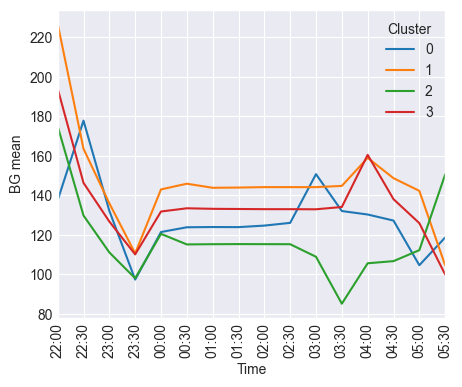

In [39]:
def plot_cluster_bg_profiles(df, col):
    print('BG mean in the nocturnal period for each cluster')
    colours = cluster_colours()
    fig, ax = plt.subplots(figsize=(5,4))
    sns.lineplot(df, x='time', y=col, hue='cluster', palette=colours, ax=ax)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=30))
    plt.xticks(rotation=90)
    plt.xlim(df['time'].min(), df['time'].max())
    plt.xlabel('Time')
    plt.ylabel('BG mean')
    plt.legend(title='Cluster')
    plt.savefig(FIGURES_DIR / f'cluster_nocturnal_bg_profiles_{col.replace(" ", "_")}.png', bbox_inches='tight')
    plt.show()

plot_cluster_bg_profiles(df_long_bg, 'bg mean')

Cluster 0 and cluster 1 show a similar profile but at different elevations of blood glucose. Lets first have a look at DTW similarity for absolute values, and then we can normalise the data to focus on the shape of the profile.

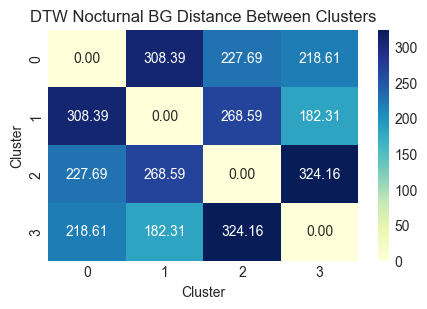

In [40]:
def heatmap_dtw_distance(df, col, title):
    clusters = sorted(df['cluster'].unique())
    n = len(clusters)
    dtw_matrix = np.zeros((n, n))

    for i, c1 in enumerate(clusters):
        arr1 = df[df['cluster'] == c1][col].to_list()
        for j, c2 in enumerate(clusters):
            if i <= j:
                arr2 = df[df['cluster'] == c2][col].to_list()
                distance, _, _, _ = dtw(arr1, arr2, dist=lambda x, y: abs(x - y))
                dtw_matrix[i, j] = distance
                dtw_matrix[j, i] = distance
    
    dtw_df = pd.DataFrame(dtw_matrix, index=clusters, columns=clusters)
    
    plt.figure(figsize=(5, 3))
    sns.heatmap(dtw_df, annot=True, fmt=".2f", cmap="YlGnBu")
    plt.title(title)
    plt.xlabel("Cluster")
    plt.ylabel("Cluster")
    plt.savefig(FIGURES_DIR / (title.replace(' ', '_') + '.png'), bbox_inches='tight')
    plt.show()

heatmap_dtw_distance(df_long_bg, 'bg mean', "DTW Nocturnal BG Distance Between Clusters")

In [41]:
df_long_bg.groupby('cluster').mean()

,time,bg mean
cluster,,
0,1900-01-02 01:45:00,128.219816
1,1900-01-02 01:45:00,146.544453
2,1900-01-02 01:45:00,117.440735
3,1900-01-02 01:45:00,135.341002


In [42]:
segments = {1: ('1900-01-01 22:00:00', '1900-01-02 00:00:00'),
            2: ('1900-01-02 00:30:00', '1900-01-02 02:00:00'),
            3: ('1900-01-02 00:02:30', '1900-01-02 06:00:00')}

def seg(time):
    for k, v in segments.items():
        date_format = '%Y-%m-%d %H:%M:%S'
        start = datetime.strptime(v[0], date_format)
        end = datetime.strptime(v[1], date_format)
        if time >= start and time <= end:
            return k
df_long_bg['segment'] = df_long_bg['time'].apply(seg)
df_long_bg.groupby('segment')['bg mean'].std()

segment
1    33.297364
2    11.195338
3    19.471914
Name: bg mean, dtype: float64

DTW measures the distance between two time series, which is useful for comparing the overnight glucose profiles of different clusters. The heatmap shows the DTW distances between each pair of clusters, with lower values indicating more similar profiles. These results show that clusters 0 and 2 are the most similar, and cluster 3 in general is moderately dissimilar to others. Cluster 1 is the most dissimilar to others on aggregate, with cluster 0 being a mixed result. The most dissimilar clusters are 1 and 2, due to the difference in absolute values and apparent shape. Cluster 1 is the one with the highest overnight glucose levels, and cluster 3 is the one with the lowest overnight glucose levels. Given the distance measure is based on absolute values, and the difference between these, it is not picking up on the level of fluctuation, i.e. the shape. In fact the shape of profiles 0 and 1 are visibly similar. This suggests that there may be a relationship between overnight glucose levels and the shape of the profile. If we normalise the data it will further focus on the shape rather than the absolute values, which may be more useful for comparing clusters, given that clusters may be focusing on people with generally higher or lower overnight glucose levels.

BG mean in the nocturnal period for each cluster


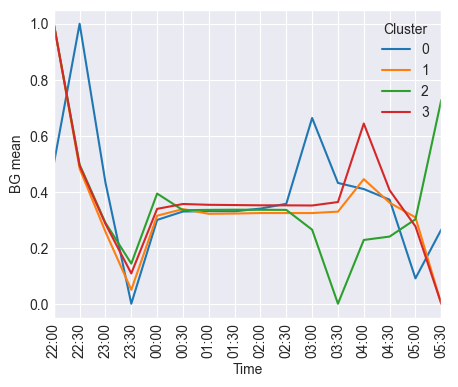

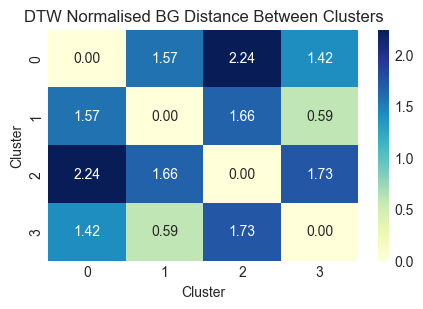

In [43]:
for c, df_c in df_long_bg.groupby('cluster'):
    df_c['bg mean norm'] = (df_c['bg mean'] - df_c['bg mean'].min()) / (df_c['bg mean'].max() - df_c['bg mean'].min())
    df_long_bg.loc[df_long_bg['cluster'] == c, 'bg mean norm'] = df_c['bg mean norm']

plot_cluster_bg_profiles(df_long_bg, 'bg mean norm')

heatmap_dtw_distance(df_long_bg, 'bg mean norm', "DTW Normalised BG Distance Between Clusters")


These DTW values focus on the shapes of the cluster profiles and provide an alternative perspective on the differences between the clusters. Clusters 3 and 0 have the greatest difference in shape according to the DTW values, which aligns with the observed profiles. Given that we want to understand how relationships between COB and IOB for these groups impact BG, we assume there is a lagged response. Insulin absorption rates can be impacted by a number of different factors including does, insulin mixtures, the site of (and excercise around) the injected area, temperature, and more. Onset of action can range from 5-30 minutes for fast acting insulin, peaking between 15 minutes to 4 hours following the bolus~\cite{Donnor2000}. This means that the impact of COB and IOB on BG can be delayed, and we need to take this into account when analysing the data. We can do this by shifting the COB and IOB values by a certain number of intervals, which will allow us to see how the relationships change over time. The process of shifting the data is known as lagging, and it can be done by using the `shift` method in pandas. We can then compare the relationships between COB, IOB, and BG for different clusters by looking at the correlation coefficients between these variables at different lags. Given our area of interest is the disruption of diurnal patterns that align with the night time period, and we define for the purpose of this study the night time period as between 22:00 and 06:00, we can look at the lagged relationships between COB, IOB ranging up to 4 hours before and therefore revert to our original 17:00-11:00 period for the next analysis.

[1] Donnor T, Sarkar S. Insulin- Pharmacology, Therapeutic Regimens and Principles of Intensive Insulin Therapy. [Updated 2023 Feb 15]. In: Feingold KR, Ahmed SF, Anawalt B, et al., editors. Endotext [Internet]. South Dartmouth (MA): MDText.com, Inc.; 2000-. Available from: https://www.ncbi.nlm.nih.gov/books/NBK278938/

The following Mixed Linear Model tests for if the magnitudes of the BG means are significantly different. answering: "Is the difference in the BG means between these clusters (as shown above) statistically significant, or could it be due to chance?"

In [44]:
# Analysing statistical significance of the mean differences using a MixedLM
df_anovarm = df_overnight[['night_start_date', 'bg mean', 'cluster_label']].reset_index().copy()
df_anovarm['night_id'] = df_anovarm['id'].astype(str) + '_' + df_anovarm['night_start_date'].astype(str)
df_anovarm['time'] = df_anovarm['datetime'].dt.time
df_anovarm['cluster_label'] = pd.Categorical(df_anovarm['cluster_label'],
                                              categories=[3, 0, 1, 2],
                                              ordered=False)


# Define the model formula
# bg mean ~ C(cluster_label) * C(time)
# The 'C()' treats cluster_label and time as categorical variables
# The '*' includes the main effects and the interaction effect
# The 'groups' parameter specifies the repeated measures variable
model = smf.mixedlm("Q('bg mean') ~ C(cluster_label) * C(time)", data=df_anovarm, groups=df_anovarm['night_id'])
result = model.fit()
print(result.summary())

                                Mixed Linear Model Regression Results
Model:                            MixedLM               Dependent Variable:               Q('bg mean')
No. Observations:                 14605                 Method:                           REML        
No. Groups:                       922                   Scale:                            974.1316    
Min. group size:                  15                    Log-Likelihood:                   -72210.0089 
Max. group size:                  16                    Converged:                        Yes         
Mean group size:                  15.8                                                                
------------------------------------------------------------------------------------------------------
                                                        Coef.   Std.Err.    z    P>|z|  [0.025  0.975]
------------------------------------------------------------------------------------------------------
Int

In [45]:
scaled_cols = ['cob_mean_scaled','iob_mean_scaled', 'bg_mean_scaled']
scaler = StandardScaler()
df_to_compare[scaled_cols] = scaler.fit_transform(df_to_compare[variables])

Prior to any regression being carried out, we will ensure that we have complete time series and that the data is stationary. This is necessary more due to the needs OLS linear regression rather than any non-linear model, but is a cautionary approach. This at first ensures regular intervals, then differences the data, before then checking for stationarity for each variable first using an ACF and then a ADF test.

In [46]:
var_cols = ['bg_mean_scaled', 'cob_mean_scaled', 'iob_mean_scaled']
all_cols = ['night_start_date', 'cluster_label'] + var_cols
df_reg = df_to_compare[all_cols].reset_index().copy()
df_reg['datetime'] = pd.to_datetime(df_reg['datetime'])
df_reg['night_id'] = df_reg['id'].astype(str) + '_' + df_reg['night_start_date'].dt.date.astype(str)
nights = df_reg['night_id'].unique().tolist()

complete_series = []
for night in nights:
    night_data = df_reg[df_reg['night_id'] == night]
    start_time = night_data['datetime'].min()
    end_time = night_data['datetime'].max()
    full_range = pd.date_range(start=start_time, end=end_time, freq='30min')
    full_df = pd.DataFrame({'datetime': full_range, 'night_id': night})
    complete_series.append(full_df)

complete_df = pd.concat(complete_series)
df_reg = pd.merge(complete_df, df_reg, on=['night_id', 'datetime'], how='left')
df_reg[var_cols] = df_reg.groupby('night_id')[var_cols].transform(
    lambda x: x.interpolate(method='linear', axis=0)
)
df_reg.reset_index(level=0, drop=True, inplace=True)
fill_cols = ['id', 'night_start_date', 'cluster_label']
df_reg[fill_cols] = df_reg.groupby('night_id')[fill_cols].ffill().bfill()
df_reg['bg'] = df_reg.groupby('night_id')['bg_mean_scaled'].diff()
df_reg['cob'] = df_reg.groupby('night_id')['cob_mean_scaled'].diff()
df_reg['iob'] = df_reg.groupby('night_id')['iob_mean_scaled'].diff()
df_reg['cluster_label'] = df_reg['cluster_label'].astype(int)

Night: 79526193_2018-04-03, Col: bg


<Figure size 600x200 with 0 Axes>

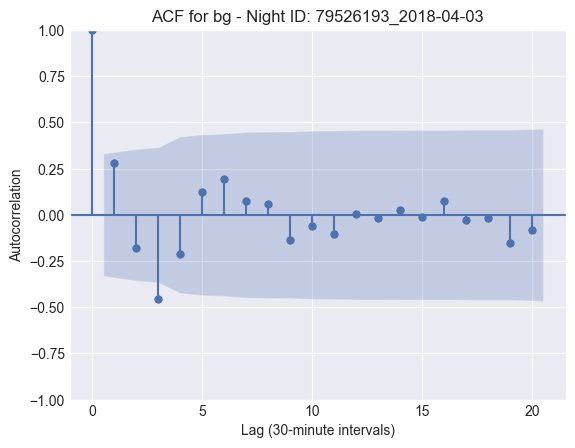

--- ADF Test for bg on Night ID: 79526193_2018-04-03 ---
ADF Statistic: -4.5730
P-value: 0.0001
Conclusion: The series is stationary (Reject Null Hypothesis).
--------------------------------------------------
Night: 79526193_2018-04-03, Col: cob


<Figure size 600x200 with 0 Axes>

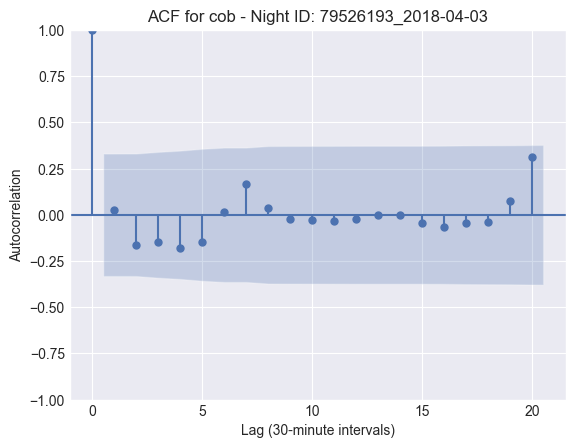

--- ADF Test for cob on Night ID: 79526193_2018-04-03 ---
ADF Statistic: -5.9467
P-value: 0.0000
Conclusion: The series is stationary (Reject Null Hypothesis).
--------------------------------------------------
Night: 79526193_2018-04-03, Col: iob


<Figure size 600x200 with 0 Axes>

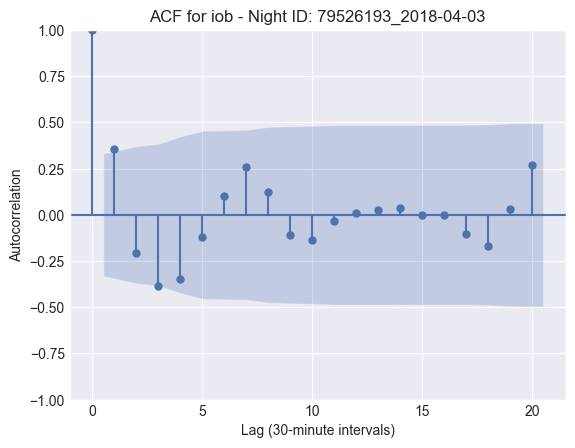

--- ADF Test for iob on Night ID: 79526193_2018-04-03 ---
ADF Statistic: -4.1897
P-value: 0.0007
Conclusion: The series is stationary (Reject Null Hypothesis).
--------------------------------------------------
Night: 28768536_2017-11-24, Col: bg


<Figure size 600x200 with 0 Axes>

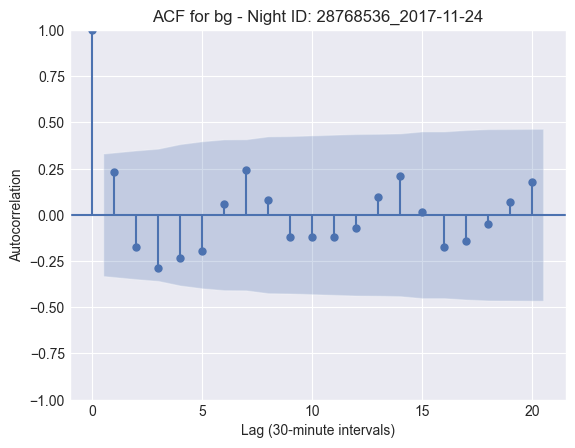

--- ADF Test for bg on Night ID: 28768536_2017-11-24 ---
ADF Statistic: -4.3475
P-value: 0.0004
Conclusion: The series is stationary (Reject Null Hypothesis).
--------------------------------------------------
Night: 28768536_2017-11-24, Col: cob


<Figure size 600x200 with 0 Axes>

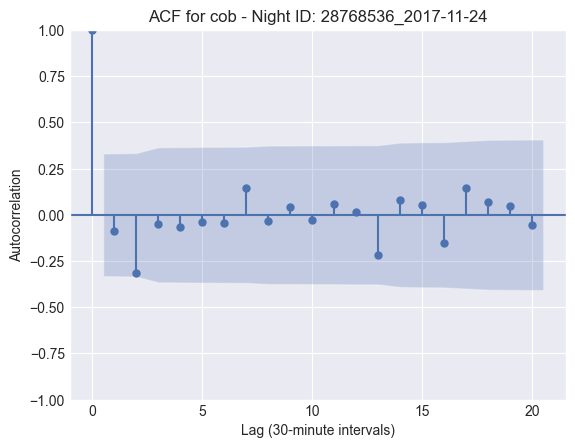

--- ADF Test for cob on Night ID: 28768536_2017-11-24 ---
ADF Statistic: -6.1738
P-value: 0.0000
Conclusion: The series is stationary (Reject Null Hypothesis).
--------------------------------------------------
Night: 28768536_2017-11-24, Col: iob


<Figure size 600x200 with 0 Axes>

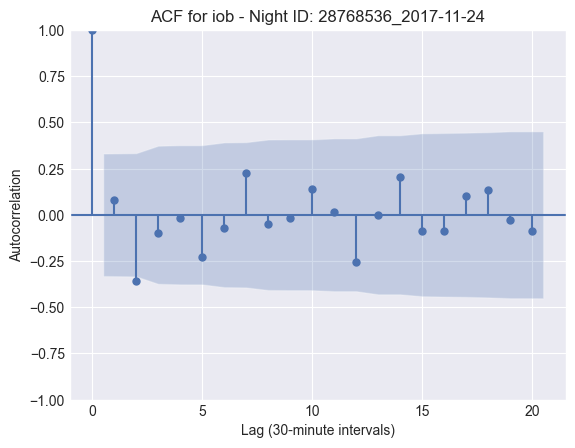

--- ADF Test for iob on Night ID: 28768536_2017-11-24 ---
ADF Statistic: -3.6169
P-value: 0.0054
Conclusion: The series is stationary (Reject Null Hypothesis).
--------------------------------------------------
Night: 15558575_2018-08-28, Col: bg


<Figure size 600x200 with 0 Axes>

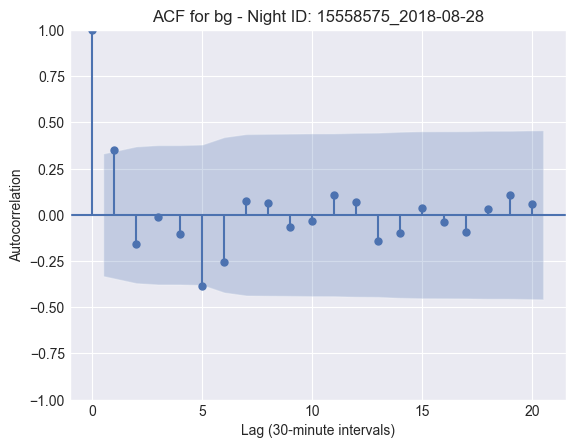

--- ADF Test for bg on Night ID: 15558575_2018-08-28 ---
ADF Statistic: -4.3947
P-value: 0.0003
Conclusion: The series is stationary (Reject Null Hypothesis).
--------------------------------------------------
Night: 15558575_2018-08-28, Col: cob


<Figure size 600x200 with 0 Axes>

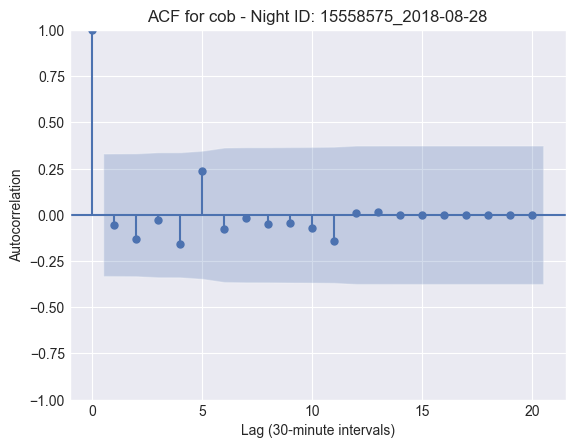

--- ADF Test for cob on Night ID: 15558575_2018-08-28 ---
ADF Statistic: -5.2887
P-value: 0.0000
Conclusion: The series is stationary (Reject Null Hypothesis).
--------------------------------------------------
Night: 15558575_2018-08-28, Col: iob


<Figure size 600x200 with 0 Axes>

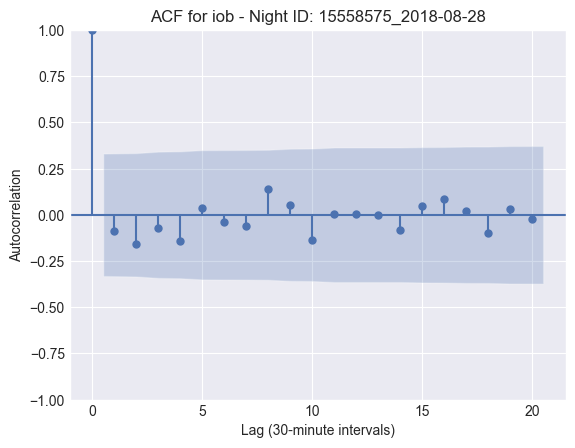

--- ADF Test for iob on Night ID: 15558575_2018-08-28 ---
ADF Statistic: -1.3689
P-value: 0.5971
Conclusion: The series is non-stationary (Fail to Reject Null Hypothesis).
--------------------------------------------------


In [47]:
random.seed(42)
rand_nights = random.sample(nights, 3)
diff_cols = ['bg',  'cob', 'iob']
for night in rand_nights:
    for col in diff_cols:
        series = df_reg[df_reg['night_id']==night][col].dropna()
        print(f'Night: {night}, Col: {col}')
        plt.figure(figsize=(6, 2))
        plot_acf(series, lags=20, title=f'ACF for {col} - Night ID: {night}')
        plt.xlabel('Lag (30-minute intervals)')
        plt.ylabel('Autocorrelation')
        plt.grid(True)
        plt.show()

        result = adfuller(series)
        p_value = result[1]
        print(f"--- ADF Test for {col} on Night ID: {night} ---")
        print(f"ADF Statistic: {result[0]:.4f}")
        print(f"P-value: {p_value:.4f}")
        if p_value < 0.05:
            print("Conclusion: The series is stationary (Reject Null Hypothesis).")
        else:
            print("Conclusion: The series is non-stationary (Fail to Reject Null Hypothesis).")
        print("-" * 50)

Now check the stationarity of all nights and average the p-value and statistic for each variable

In [48]:
def adf_test(df, variables):
    adf_results = []
    for night in df['night_id'].unique().tolist():
        for col in variables:
            series = df[df['night_id']==night][col].dropna()
            if len(series) > 10 and len(np.unique(series)) > 1:
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore", RuntimeWarning)
                    result = adfuller(series)
                adf_results.append({'night_id': night, 'variable': col, 'pvalue': result[1], 'statistic': result[0]})
            else:
                continue

    adf_df = pd.DataFrame(adf_results)
    average_results = adf_df.groupby('variable')[['pvalue', 'statistic']].mean()
    print(average_results)

print('------------ ADF RESULTS FROM UNDIFFERENCED VARIABLES --------------')
adf_test(df_reg, var_cols)
print('------------ ADF RESULTS FROM DIFFERENCED VARIABLES --------------')
adf_test(df_reg, diff_cols)


------------ ADF RESULTS FROM UNDIFFERENCED VARIABLES --------------
                   pvalue     statistic
variable                               
bg_mean_scaled   0.243955 -2.433774e+00
cob_mean_scaled  0.164836 -5.229074e+11
iob_mean_scaled  0.221742 -2.493592e+00
------------ ADF RESULTS FROM DIFFERENCED VARIABLES --------------
            pvalue     statistic
variable                        
bg        0.068582 -3.861489e+00
cob       0.054813 -1.035255e+14
iob       0.060420 -4.505762e+00


The p-values are still above significance but slightly, and the statistics are massively negative which is indicative of an extremely strong rejection of stationarity. Now, we can gather results regarding the cross correlation.

In [49]:
variable_pairs = list(itertools.permutations(diff_cols, 2))
all_ccf_results = []
n = 35
max_plot_lag = 5

for night in nights:
    night_df = df_reg[df_reg['night_id'] == night].dropna(subset=diff_cols).reset_index(drop=True)
    cluster = night_df['cluster_label'][0]
    if len(night_df) == n:
        for var1, var2 in variable_pairs:
            series1 = night_df[var1].values
            series2 = night_df[var2].values
            ccf_values = ccf(series1, series2)
            for i, ccf_val in enumerate(ccf_values):
                lag = i - (n - 1)
                if -max_plot_lag <= lag <= max_plot_lag:
                    record = {
                        'night_id': night,
                        'cluster': cluster,
                        'leading_variable': var2,
                        'lagging_variable': var1,
                        'lag': -lag,
                        'ccf_value': ccf_val
                    }
                    all_ccf_results.append(record)

ccf_df = pd.DataFrame(all_ccf_results)

print("Sample of the CCF results:")
print(ccf_df.head())

C:\.env\master_project\Lib\site-packages\statsmodels\tsa\stattools.py:1179: RuntimeWarning: invalid value encountered in divide
  ret = cvf / (np.std(x) * np.std(y))


Sample of the CCF results:
              night_id  cluster leading_variable lagging_variable  lag  \
0  15558575_2018-04-17        3              cob               bg    5   
1  15558575_2018-04-17        3              cob               bg    4   
2  15558575_2018-04-17        3              cob               bg    3   
3  15558575_2018-04-17        3              cob               bg    2   
4  15558575_2018-04-17        3              cob               bg    1   

   ccf_value  
0   0.124836  
1  -0.605010  
2  -0.866932  
3  -0.863443  
4  -0.254574  


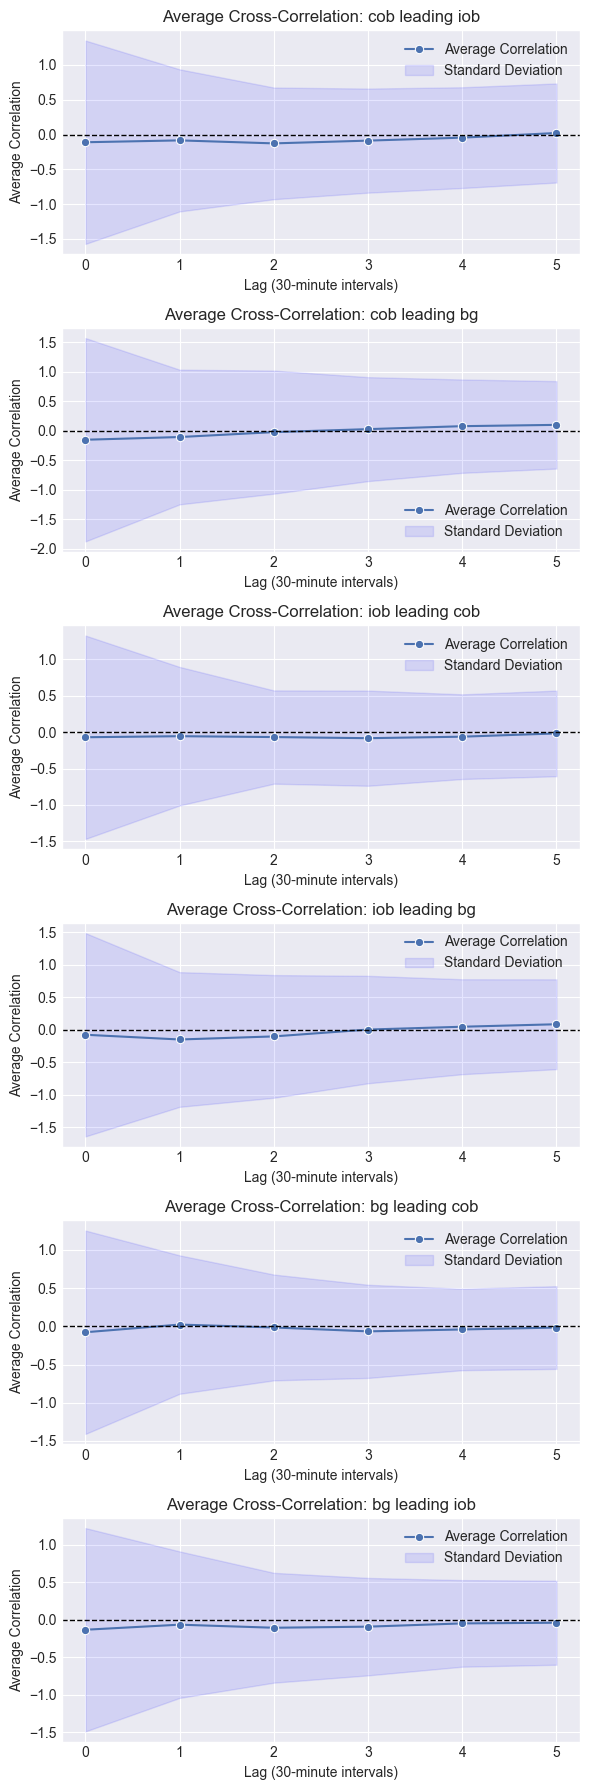

In [50]:
average_ccf = ccf_df.groupby(
    ['leading_variable', 'lagging_variable', 'lag']
).ccf_value.agg(['mean', 'std']).reset_index()

variable_pairs = list(itertools.permutations(ccf_df['leading_variable'].unique(), 2))

fig, axes = plt.subplots(nrows=len(variable_pairs), ncols=1, figsize=(6, 3 * len(variable_pairs)), squeeze=False)
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('deep')

for i, (var1, var2) in enumerate(variable_pairs):
    ax = axes[i, 0]

    plot_data = average_ccf[
        (average_ccf['leading_variable'] == var1) &
        (average_ccf['lagging_variable'] == var2)
    ]

    sns.lineplot(
        data=plot_data,
        x='lag',
        y='mean',
        #hue='cluster',
        marker='o',
        ax=ax,
        label='Average Correlation'
    )

    ax.fill_between(
        plot_data['lag'],
        plot_data['mean'] - plot_data['std'],
        plot_data['mean'] + plot_data['std'],
        color='blue',
        alpha=0.1,
        label='Standard Deviation'
    )

    ax.axhline(0, color='black', linestyle='--', linewidth=1)
    ax.set_title(f'Average Cross-Correlation: {var1} leading {var2}')
    ax.set_xlabel('Lag (30-minute intervals)')
    ax.set_ylabel('Average Correlation')
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.show()

In [51]:
average_ccf[['mean','std']].describe()

,mean,std
count,36.000000,36.000000
mean,-0.047785,0.884992
std,0.064390,0.313128
min,-0.151277,0.533176
25%,-0.088556,0.652343
50%,-0.063993,0.769586
75%,-0.015333,1.024170
max,0.101201,1.724612


In [52]:
# Overall means of CCF
mean_ccf_table = ccf_df.groupby(
    ['leading_variable', 'lagging_variable', 'lag']
)['ccf_value'].mean().reset_index()

mean_ccf_pivot = mean_ccf_table.pivot_table(
    index=['leading_variable', 'lagging_variable'],
    columns='lag',
    values='ccf_value'
)
print('CCF means for lags and variable permutations')
print(mean_ccf_pivot.round(3))

std_ccf_table = ccf_df.groupby(
    ['leading_variable', 'lagging_variable', 'lag']
)['ccf_value'].std().reset_index()

std_ccf_pivot = std_ccf_table.pivot_table(
    index=['leading_variable', 'lagging_variable'],
    columns='lag',
    values='ccf_value'
)
print('\nCCF SDs for lags and variable permutations')
print(std_ccf_pivot.round(3))

CCF means for lags and variable permutations
lag                                    0      1      2      3      4      5
leading_variable lagging_variable                                          
bg               cob              -0.077  0.023 -0.015 -0.066 -0.041 -0.016
                 iob              -0.133 -0.065 -0.106 -0.091 -0.048 -0.039
cob              bg               -0.151 -0.105 -0.022  0.029  0.079  0.101
                 iob              -0.111 -0.084 -0.127 -0.088 -0.045  0.022
iob              bg               -0.075 -0.148 -0.101  0.005  0.048  0.086
                 cob              -0.071 -0.056 -0.068 -0.084 -0.063 -0.018

CCF SDs for lags and variable permutations
lag                                    0      1      2      3      4      5
leading_variable lagging_variable                                          
bg               cob               1.331  0.906  0.693  0.610  0.533  0.542
                 iob               1.357  0.978  0.733  0.650  0.578  0.561

In [53]:
# Means by cluster of CCF
mean_ccf_cluster_table = ccf_df.groupby(
    ['cluster', 'leading_variable', 'lagging_variable', 'lag']
)['ccf_value'].mean().reset_index()

mean_ccf_cluster_pivot = mean_ccf_cluster_table.pivot_table(
    index=['cluster', 'leading_variable', 'lagging_variable'],
    columns='lag',
    values='ccf_value'
)
print('CCF means for lags and variable permutations')
print(mean_ccf_pivot.round(3))

std_ccf_cluster_table = ccf_df.groupby(
    ['cluster', 'leading_variable', 'lagging_variable', 'lag']
)['ccf_value'].std().reset_index()

std_ccf_cluster_pivot = std_ccf_cluster_table.pivot_table(
    index=['cluster', 'leading_variable', 'lagging_variable'],
    columns='lag',
    values='ccf_value'
)
print('\nCCF SDs for lags and variable permutations')
print(std_ccf_pivot.round(3))

CCF means for lags and variable permutations
lag                                    0      1      2      3      4      5
leading_variable lagging_variable                                          
bg               cob              -0.077  0.023 -0.015 -0.066 -0.041 -0.016
                 iob              -0.133 -0.065 -0.106 -0.091 -0.048 -0.039
cob              bg               -0.151 -0.105 -0.022  0.029  0.079  0.101
                 iob              -0.111 -0.084 -0.127 -0.088 -0.045  0.022
iob              bg               -0.075 -0.148 -0.101  0.005  0.048  0.086
                 cob              -0.071 -0.056 -0.068 -0.084 -0.063 -0.018

CCF SDs for lags and variable permutations
lag                                    0      1      2      3      4      5
leading_variable lagging_variable                                          
bg               cob               1.331  0.906  0.693  0.610  0.533  0.542
                 iob               1.357  0.978  0.733  0.650  0.578  0.561

In [54]:
mean_ccf_table = mean_ccf_cluster_pivot.to_latex(
    index=True,
    float_format='%.2f',
    caption='Mean cross correlation coefficients by cluster',
    label='tab:mean_ccf',
 #   header=['Cluster', 'Leading Variable', 'Lagging Variable', '0', '1', '2', '3', '4', '5'],
)
print(mean_ccf_table)

\begin{table}
\caption{Mean cross correlation coefficients by cluster}
\label{tab:mean_ccf}
\begin{tabular}{lllrrrrrr}
\toprule
 &  & lag & 0 & 1 & 2 & 3 & 4 & 5 \\
cluster & leading_variable & lagging_variable &  &  &  &  &  &  \\
\midrule
\multirow[t]{6}{*}{0} & \multirow[t]{2}{*}{bg} & cob & -0.09 & 0.06 & 0.01 & -0.01 & -0.01 & -0.02 \\
 &  & iob & -0.08 & -0.08 & -0.10 & -0.08 & 0.02 & 0.04 \\
\cline{2-9}
 & \multirow[t]{2}{*}{cob} & bg & -0.40 & -0.28 & 0.06 & 0.01 & 0.03 & 0.28 \\
 &  & iob & -0.16 & -0.12 & -0.16 & -0.14 & -0.09 & 0.16 \\
\cline{2-9}
 & \multirow[t]{2}{*}{iob} & bg & -0.12 & -0.22 & -0.11 & -0.00 & 0.04 & 0.19 \\
 &  & cob & -0.04 & 0.01 & -0.02 & -0.04 & -0.02 & 0.04 \\
\cline{1-9} \cline{2-9}
\multirow[t]{6}{*}{1} & \multirow[t]{2}{*}{bg} & cob & 0.07 & 0.09 & 0.01 & -0.14 & -0.14 & -0.05 \\
 &  & iob & -0.02 & -0.01 & 0.09 & -0.07 & -0.14 & -0.05 \\
\cline{2-9}
 & \multirow[t]{2}{*}{cob} & bg & 0.04 & -0.16 & -0.17 & 0.08 & 0.17 & 0.16 \\
 &  & iob & 0.05 & 

In [55]:
std_ccf_table = std_ccf_cluster_pivot.to_latex(
    index=True,
    float_format='%.2f',
    caption='Standard deviation of means for cross correlation coefficients by cluster',
    label='tab:std_ccf',
 #   header=['Cluster', 'Leading Variable', 'Lagging Variable', '0', '1', '2', '3', '4', '5'],
)
print(std_ccf_table)

\begin{table}
\caption{Standard deviation of means for cross correlation coefficients by cluster}
\label{tab:std_ccf}
\begin{tabular}{lllrrrrrr}
\toprule
 &  & lag & 0 & 1 & 2 & 3 & 4 & 5 \\
cluster & leading_variable & lagging_variable &  &  &  &  &  &  \\
\midrule
\multirow[t]{6}{*}{0} & \multirow[t]{2}{*}{bg} & cob & 0.94 & 0.76 & 0.74 & 0.56 & 0.64 & 0.58 \\
 &  & iob & 0.96 & 0.78 & 0.80 & 0.62 & 0.65 & 0.69 \\
\cline{2-9}
 & \multirow[t]{2}{*}{cob} & bg & 1.67 & 1.24 & 1.17 & 1.02 & 0.97 & 0.81 \\
 &  & iob & 1.06 & 0.84 & 0.69 & 0.97 & 0.71 & 0.88 \\
\cline{2-9}
 & \multirow[t]{2}{*}{iob} & bg & 1.41 & 0.99 & 1.01 & 0.86 & 0.93 & 0.72 \\
 &  & cob & 0.84 & 0.58 & 0.66 & 0.72 & 0.60 & 0.71 \\
\cline{1-9} \cline{2-9}
\multirow[t]{6}{*}{1} & \multirow[t]{2}{*}{bg} & cob & 1.33 & 0.72 & 0.77 & 0.74 & 0.67 & 0.50 \\
 &  & iob & 0.88 & 0.73 & 0.64 & 0.68 & 0.65 & 0.49 \\
\cline{2-9}
 & \multirow[t]{2}{*}{cob} & bg & 0.85 & 0.82 & 1.01 & 0.85 & 0.73 & 0.56 \\
 &  & iob & 0.93 & 1.03 & 

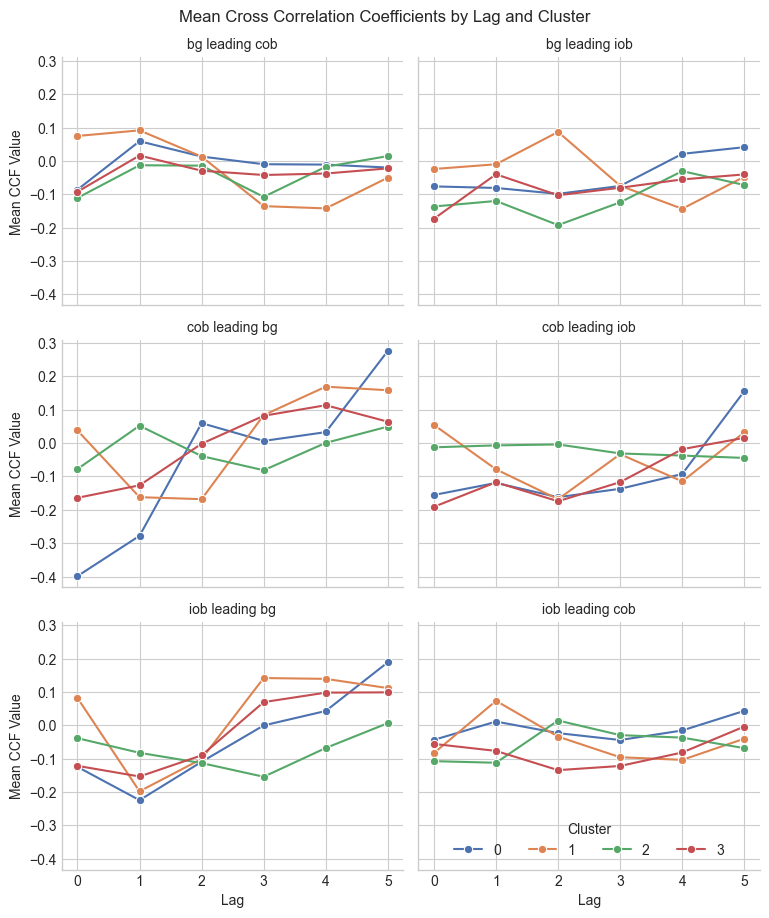

In [56]:
mean_ccf_df = ccf_df.groupby(['cluster', 'leading_variable', 'lagging_variable', 'lag'])['ccf_value'].mean().reset_index()
mean_ccf_df['variable_pair'] = mean_ccf_df['leading_variable'] + ' leading ' + mean_ccf_df['lagging_variable']
palette = sns.color_palette("deep", n_colors=mean_ccf_df['cluster'].nunique())
g = sns.FacetGrid(mean_ccf_df, col='variable_pair', hue='cluster', col_wrap=2, palette=palette, height=3, aspect=1.3)
g.map(sns.lineplot, 'lag', 'ccf_value', marker='o')
handles, labels = g.axes.flat[0].get_legend_handles_labels()
for ax in g.axes.flat:
    if ax.get_legend() is not None:
        ax.get_legend().remove()
plt.legend(title='Cluster', ncol=4, loc='lower center')
g.set_axis_labels('Lag', 'Mean CCF Value')
g.set_titles(col_template='{col_name}')
plt.suptitle('Mean Cross Correlation Coefficients by Lag and Cluster', y=1.015)
plt.savefig(FIGURES_DIR / f'cross_correlation_coefficients.png', dpi=300, bbox_inches='tight')
plt.show()

Now we have scaled columns for the means of COB, IOB and BG, to carry out lagged regression over lagged values of COB and IOB, we can use the `shift` method in pandas to create lagged versions of these columns. We can then use the `statsmodels` library to perform regression analysis on the lagged values of COB and IOB against BG. This will allow us to see how the relationships between these variables change over time, and how they differ between clusters. The following is the code to do this on the overnight period, and we can then look at the results for each cluster.

Finally, lets analyse the correlations between the variables in the overnight period for each cluster, to see how they relate to each other. This will allow us to see how the relationships between COB, IOB and BG differ between clusters, and how they change over time. We'll look at Pearson correlation coefficients to study the linear relationships for each cluster and lag, and then Spearman correlation coefficients to study the non-linear relationships for each cluster and lag. This will allow us to see how the relationships between COB, IOB and BG differ between clusters, and how they change over time. I want to test whether the data is normally distributed, which is a requirement for Pearson correlation. If the data is not normally distributed, we can use Spearman correlation, which does not require normality. We can use the Kolmogorov-Smirnov test to check for normality. The null hypothesis of the Kolmogorov-Smirnov (KS) test (https://www.itl.nist.gov/div898/handbook/eda/section3/eda35g.htm is based on the maximum distance between the empirical distribution function and a normal cumulative distribution function and is appropriate for large sample sizes, in comparison to - for example - the Shapiro-Wilk test. The null hypothesis is that the data is normally distributed, and the alternative hypothesis is that the data is not normally distributed. If the p-value is less than 0.05, we reject the null hypothesis and conclude that the data is not normally distributed. The following will check if the variables are normally distributed for each cluster using the KS test.



In [57]:
night_start = time(17, 00)
def check_normality_cluster(df, col):
    results = []
    for cluster, group in df.groupby('cluster'):
        mean = group[col].mean()
        sigma = group[col].std()
        p, stat = kstest(group[col], 'norm', args=(mean, sigma))
        results.append({'cluster': cluster, 'statistic': stat, 'p-value': p})
    return pd.DataFrame(results)

def check_normality_by_time(df, col, night_start):
    results = []
    for cluster, group in df.reset_index().groupby('cluster'):
        group['time'] = group['datetime'].dt.time
        for time, time_group in group.groupby('time'):
            mean = time_group[col].mean()
            sigma = time_group[col].std()
            p, stat = kstest(time_group[col], 'norm', args=(mean, sigma))
            results.append({'cluster': cluster, 'time': time, 'statistic': stat, 'p-value': p})
    return pd.DataFrame(results)

df_ks_by_cluster = pd.DataFrame(columns=['cluster', 'statistic', 'p-value'])
df_ks_by_cluster = df_ks_by_cluster.astype({'cluster': 'int', 'statistic': 'float', 'p-value': 'float'})
variables = ['bg mean', 'cob mean', 'iob mean']
for v in variables:
    df_ks = check_normality_cluster(df_to_compare.rename(columns={'cluster_label': 'cluster'}), v)
    df_ks['variable'] = v
    df_ks_by_cluster = pd.concat([df_ks_by_cluster, df_ks])

night_start = time(17, 0)
df_ks_by_time = pd.DataFrame(columns=['cluster', 'time', 'statistic', 'p-value'])
df_ks_by_time = df_ks_by_time.astype({'cluster': 'int', 'time': 'str', 'statistic': 'float', 'p-value': 'float'})
for v in variables:
    df_ks = check_normality_by_time(df_to_compare.rename(columns={'cluster_label': 'cluster'}), v, night_start)
    df_ks['variable'] = v
    df_ks['minutes_since_night_start'] = df_ks['time'].apply(lambda t: minutes_since_night_start(t, night_start))
    df_ks['rank'] = df_ks['minutes_since_night_start'].rank(method='dense').astype(int)
    df_ks_by_time = pd.concat([df_ks_by_time, df_ks.sort_values(['cluster', 'variable', 'minutes_since_night_start'], ascending=True)])

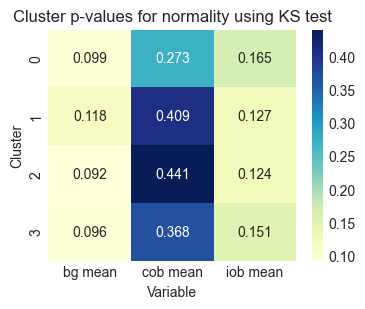

In [58]:
ks_cluster_pval_matrix = df_ks_by_cluster.pivot_table(index='cluster', columns='variable', values='p-value')

plt.figure(figsize=(4, 3))
sns.heatmap(ks_cluster_pval_matrix, annot=True, fmt=".3f", cmap="YlGnBu")
plt.xlabel('Variable')
plt.ylabel('Cluster')
plt.title('Cluster p-values for normality using KS test')
plt.savefig(FIGURES_DIR / 'ks_cluster_pval_matrix.png', bbox_inches='tight')
plt.show()

Test by variable for normality across dataset...
bg mean variable:
Skewness: 1.3232107131375277, Kurtosis: 2.47428686933728
Proportion of zero values: 0.0
KS p-value: 0.09912941466112418


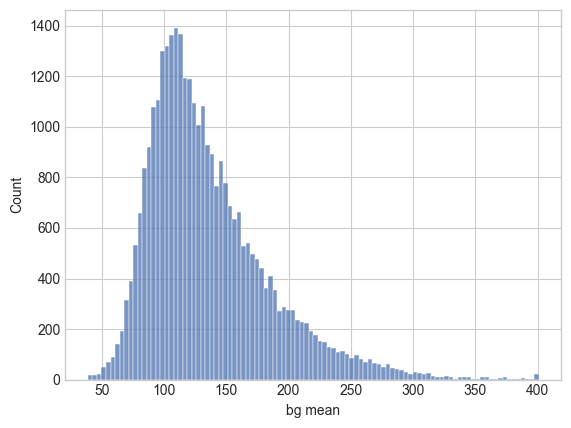

cob mean variable:
Skewness: 3.0417610935584736, Kurtosis: 10.150449498060986
Proportion of zero values: 0.7037319814317127
KS p-value: 0.14409384313616258


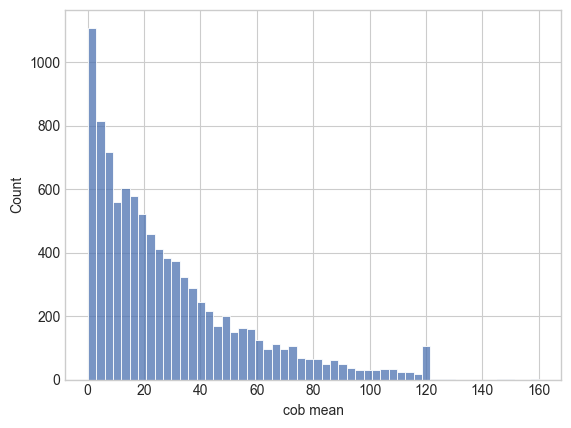

iob mean variable:
Skewness: 3.413705083305615, Kurtosis: 20.73161109003534
Proportion of zero values: 0.0030234546787197654
KS p-value: 0.18768201573270715


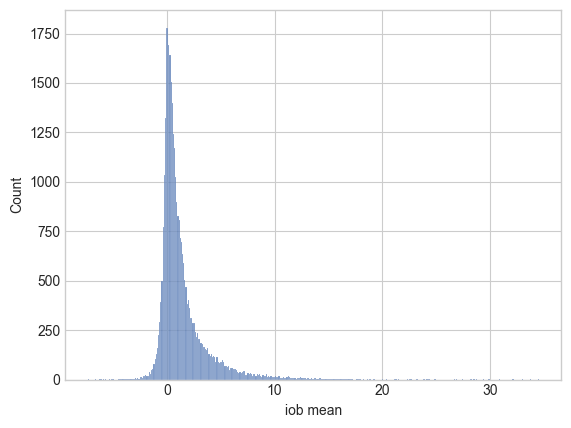

In [59]:
print('Test by variable for normality across dataset...')
for v in ['bg mean', 'cob mean', 'iob mean']:
    print(f'{v} variable:')
    var_to_test = df_to_compare.reset_index()[v]
    zero_proportion = var_to_test[var_to_test == 0].count() / len(var_to_test)
    print(f'Skewness: {var_to_test.skew()}, Kurtosis: {var_to_test.kurtosis()}')
    print('Proportion of zero values:', zero_proportion)
    var_to_test = var_to_test[var_to_test != 0] if zero_proportion > 0.6 else var_to_test
    p, stat = kstest(var_to_test, 'norm', args=(var_to_test.mean(), var_to_test.std()))
    print(f'KS p-value: {p}')
    sns.histplot(var_to_test)
    plt.show()

Cluster p-values for normality using KS test:


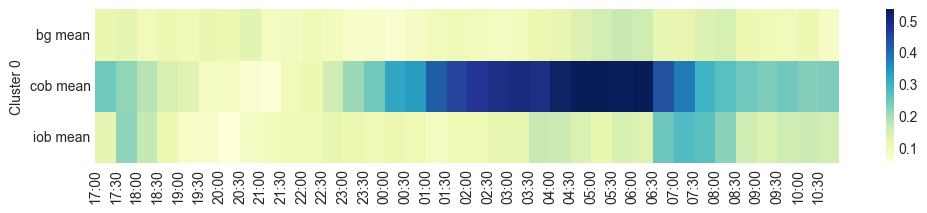

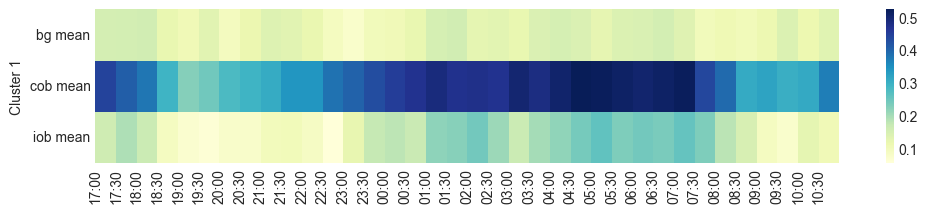

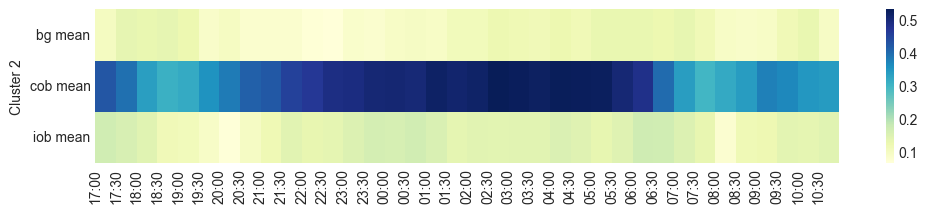

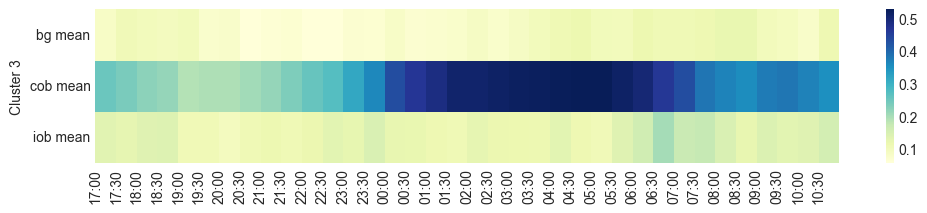

In [60]:
def format_time_to_hhmm(time_obj):
    """Formats a datetime.time object to HH:MM string."""
    return time_obj.strftime('%H:%M')

print('Cluster p-values for normality using KS test:')
x_ticks = df_ks_by_time[['rank','time']].drop_duplicates().sort_values('rank')
x_ticks['time'] = x_ticks['time'].apply(format_time_to_hhmm)
for c, group in df_ks_by_time.groupby('cluster'):
    ks_by_time_pval_matrix = group.pivot_table(index='variable', columns='rank', values='p-value')
    fig = plt.figure(figsize=(12, 2))
    sns.heatmap(ks_by_time_pval_matrix, annot=False, fmt=".3f", cmap="YlGnBu")
    plt.ylabel(f'Cluster {c}')
    plt.xlabel(None)
    plt.xticks(x_ticks['rank']-1, x_ticks['time'], rotation=90)
    plt.show()


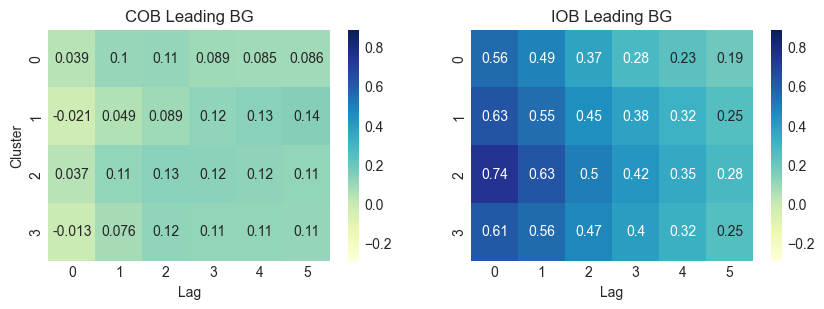

In [70]:
rel = AnalyseRelationships(df_to_compare.rename(columns={'cluster_label':'cluster'}))
df_spearman = rel.calculate_correlation(corr_type='spearman')
replacements = {
    'bg_mean_scaled': 'BG',
    'iob_lagged': 'IOB',
    'cob_lagged': 'COB',
    'vs': 'with'
}
for old, new in replacements.items():
    df_spearman['variables'] = df_spearman['variables'].str.replace(old, new)
spearman_agg = df_spearman.groupby(['variables', 'lag', 'cluster']).agg({'correlation': 'mean'}).pivot_table(
    index=['variables', 'cluster'], columns=['lag'], values='correlation').round(3).sort_index(axis=1, level=0)
vmin = df_spearman['correlation'].min()
vmax = df_spearman['correlation'].max()
fig, ax = plt.subplots(figsize=(10, 3), ncols=2)
for i, (v, df) in enumerate(spearman_agg.groupby('variables')):
    if v == 'COB with IOB':
        continue
    sns.heatmap(df.reset_index(drop=True), annot=True, cmap='YlGnBu', vmin=vmin, vmax=vmax, ax=ax[i])
    if v=='BG with COB':
        ax[i].set_title('COB Leading BG')
    else:
        ax[i].set_title('IOB Leading BG')
    ax[i].set_ylabel('Cluster' if i==0 else None)
    ax[i].set_xlabel('Lag')
plt.savefig(FIGURES_DIR / 'spearman_correlation_matrices.png', bbox_inches='tight')
plt.show()


The following looks at how the Spearman correlation changes for each variable against BG over time, for each cluster, but without a lag for COB and IOB.

Spearman correlation for variable BG with COB at lag 0:
Var(Seasonal) = 0.0065, Var(Residual) = 0.0080, Seasonal Strength = 0.449
Deseasonalised SDs:
Cluster 0 SD: 0.12
Cluster 1 SD: 0.08
Cluster 2 SD: 0.10
Cluster 3 SD: 0.08


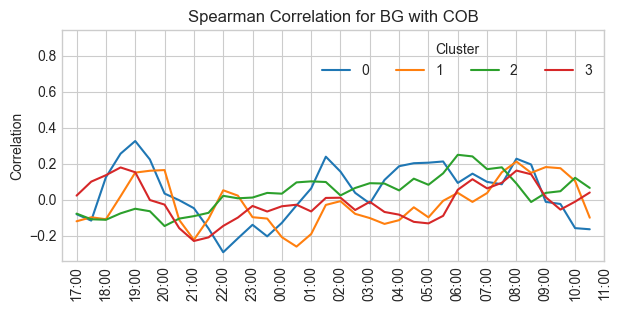

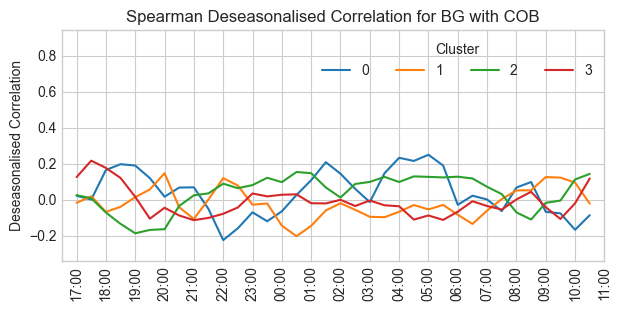

Spearman correlation for variable BG with IOB at lag 0:
Var(Seasonal) = 0.0110, Var(Residual) = 0.0040, Seasonal Strength = 0.733
Deseasonalised SDs:
Cluster 0 SD: 0.11
Cluster 1 SD: 0.05
Cluster 2 SD: 0.07
Cluster 3 SD: 0.09


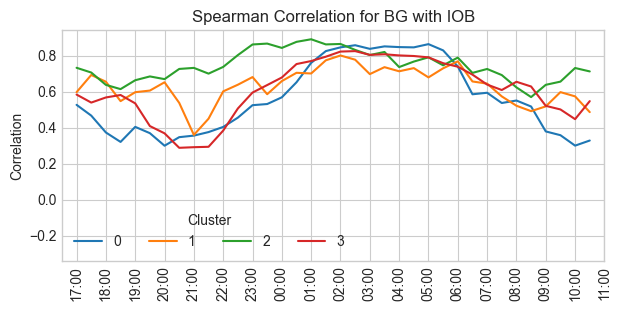

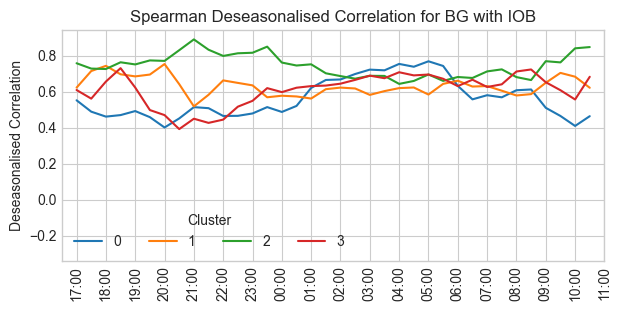

Spearman correlation for variable COB with IOB at lag 0:
Var(Seasonal) = 0.0234, Var(Residual) = 0.0087, Seasonal Strength = 0.729
Deseasonalised SDs:
Cluster 0 SD: 0.09
Cluster 1 SD: 0.10
Cluster 2 SD: 0.09
Cluster 3 SD: 0.15


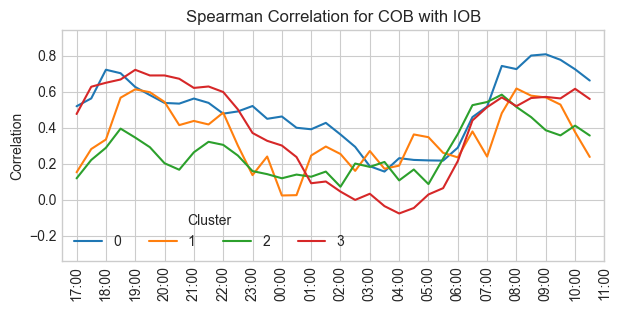

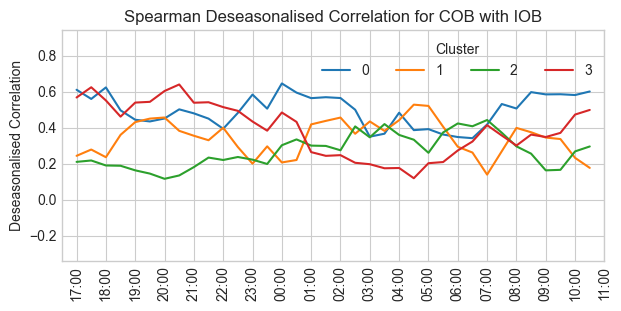

In [62]:
from numpy import var

line_colours = cluster_colours()
lag = 0
for v, group_df in df_spearman[df_spearman['lag']==lag].groupby('variables'):
    print(f'Spearman correlation for variable {v} at lag {lag}:')
    group_df = group_df.drop(columns='variables')
    period = len(df_spearman['time'].drop_duplicates())
    decomposition = seasonal_decompose(group_df['correlation'], model='additive', period=period)
    group_df['seasonal'] = decomposition.seasonal
    var_s, var_r = var(decomposition.seasonal), var(decomposition.resid)
    print(f'Var(Seasonal) = {var_s:.4f}, Var(Residual) = {var_r:.4f}, Seasonal Strength = {1 - (var_r / (var_s + var_r)):.3f}')
    group_df['deseasonalised_correlation'] = group_df['correlation'] - group_df['seasonal']
    print('Deseasonalised SDs:')
    for c, cluster_df in group_df.groupby('cluster'):
        print(f'Cluster {c} SD: {cluster_df["deseasonalised_correlation"].std():.2f}')
    for y_col in ['correlation','deseasonalised_correlation']:
        fig, ax = plt.subplots(figsize=(7, 3))
        group_df['time'] = group_df['time'].apply(lambda x: normalise_overnight_time(x, 11))
        sns.lineplot(group_df, x='time', y=y_col, hue='cluster', palette=line_colours, ax=ax)
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
        ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=60))
        plt.xlabel(None)
        plt.ylim(df_spearman['correlation'].min()-0.05,df_spearman['correlation'].max()+0.05)
        plt.xlim(group_df['time'].min()-timedelta(minutes=30), group_df['time'].max()+timedelta(minutes=30))
        plt.xticks(rotation=90)
        plt.legend(title='Cluster', ncol=4)
        plt.ylabel(f'{y_col.replace("_", " ").title()}')
        plt.title(f'Spearman {y_col.replace("_", " ").title()} for {v}')
        plt.savefig(FIGURES_DIR / f'spearman_timeseries_{v.replace(" ", "_")}_{y_col}.png', bbox_inches='tight')
        plt.show()

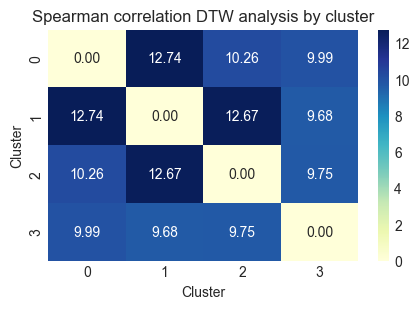

In [63]:
title = 'Spearman correlation DTW analysis by cluster'
heatmap_dtw_distance(df_spearman[df_spearman['variables']=='BG with COB'], 'correlation', title)

Now looking at Pearson correlation for comparison

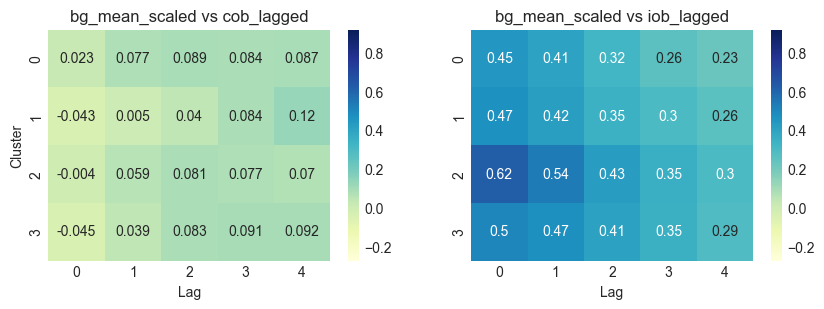

In [64]:
df_pearson = rel.calculate_correlation(corr_type='pearson')
pearson_agg = df_pearson.groupby(['variables', 'lag', 'cluster']).agg({'correlation': 'mean'}).pivot_table(
    index=['variables', 'cluster'], columns=['lag'], values='correlation').round(3).sort_index(axis=1, level=0)
vmin = df_pearson['correlation'].min()
vmax = df_pearson['correlation'].max()
fig, ax = plt.subplots(figsize=(10, 3), ncols=2)
for i, (v, df) in enumerate(pearson_agg.groupby('variables')):
    if v == 'cob_lagged vs iob_lagged':
        continue
    sns.heatmap(df.reset_index(drop=True), annot=True, cmap='YlGnBu', vmin=vmin, vmax=vmax, ax=ax[i])
    ax[i].set_title(v)
    ax[i].set_ylabel('Cluster' if i==0 else None)
    ax[i].set_xlabel('Lag')
plt.savefig(FIGURES_DIR / 'pearson_correlation_matrices.png', bbox_inches='tight')
plt.show()

Pearson correlation for variable bg_mean_scaled vs cob_lagged at lag 0:


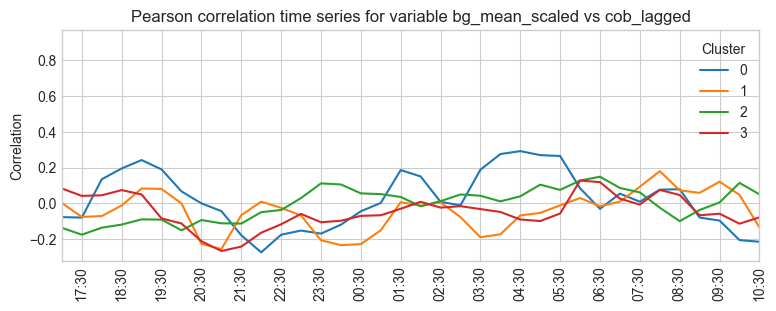

Pearson correlation for variable bg_mean_scaled vs iob_lagged at lag 0:


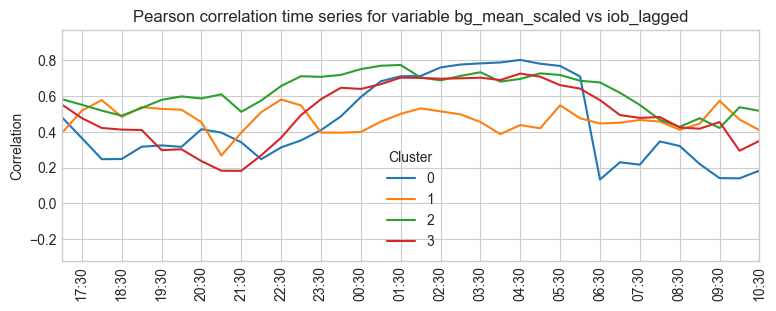

Pearson correlation for variable cob_lagged vs iob_lagged at lag 0:


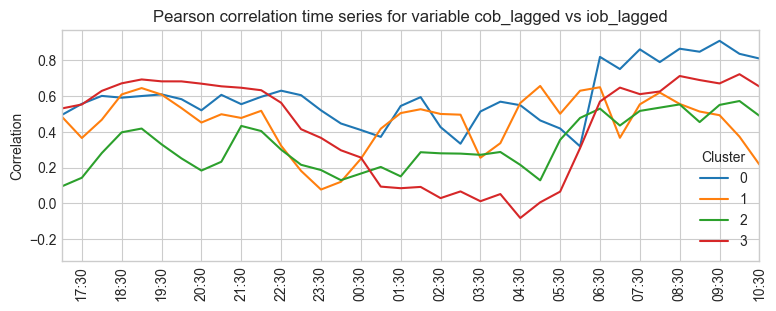

In [65]:
line_colours = cluster_colours()
lag = 0
for v, group_df in df_pearson[df_pearson['lag']==lag].groupby('variables'):
    print(f'Pearson correlation for variable {v} at lag {lag}:')
    group_df = group_df.drop(columns='variables')

    fig, ax = plt.subplots(figsize=(9, 3))
    group_df['time'] = group_df['time'].apply(lambda x: normalise_overnight_time(x, 11))
    sns.lineplot(group_df, x='time', y='correlation', hue='cluster', palette=line_colours, ax=ax)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=60))
    plt.xlabel(None)
    plt.ylim(df_pearson['correlation'].min()-0.05,df_pearson['correlation'].max()+0.05)
    plt.xlim(group_df['time'].min(), group_df['time'].max())
    plt.xticks(rotation=90)
    plt.legend(title='Cluster')
    plt.ylabel('Correlation')
    plt.title(f'Pearson correlation time series for variable {v}')
    plt.savefig(FIGURES_DIR / f'pearson_timeseries_{v.replace(" ", "_")}.png', bbox_inches='tight')
    plt.show()